In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import sys
sys.path.insert(0,"../src/")

from linear_regression import *
from main import *

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


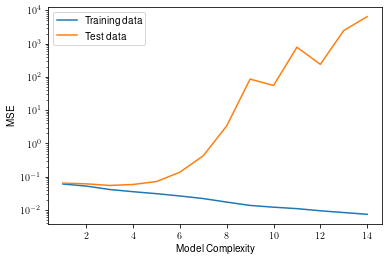

In [2]:
# Inconsistent MSE plots? Try Monte-Carlo (this is probably quite silly)
N_trials = 500
n = 100
degrees = np.arange(1, 15)

MSE_train = np.zeros([N_trials, len(degrees)])
MSE_test = np.zeros([N_trials, len(degrees)])

for trial in range(N_trials):
    x = np.random.uniform(0, 1, n)
    y = np.random.uniform(0, 1, n)
    z = FrankeFunction(x, y) + np.random.normal(0, 1, n) * 0.2

    for i, deg in enumerate(degrees):
        X = design_matrix_2D(x, y, deg)
        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size = 0.2)
        #beta = OLS_SVD_2D(X_train, z_train)
        beta = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ z_train

        MSE_train[trial,i] = MSE(z_train, X_train @ beta)
        MSE_test[trial, i] = MSE(z_test, X_test @ beta)
        
MSE_train_mean = [np.mean(MSE_train[:, i]) for i in range(len(degrees))]
MSE_test_mean = [np.mean(MSE_test[:, i]) for i in range(len(degrees))]
     
plt.semilogy(degrees, MSE_train_mean, label = "Training data")
plt.semilogy(degrees, MSE_test_mean, label = "Test data")
plt.xlabel("Model Complexity")
plt.ylabel("MSE")
plt.legend()